In [27]:
from mt.laser import get_func_gen_settings

import re
import pickle
import os
import pandas as pd
import numpy as np
import seaborn as sns
# from mt.scan import Scan
from mt.constants import ANALYSIS_SPECIMEN, SCALE_FACTOR_2D, SCALE_FACTOR_3D
# from mt.ct_utils import reslice
# from mt.visualization import visualize_region_properties, visualize_region_correlation
import matplotlib.pyplot as plt

# Particle size distributions
Load the analytics of the binned scans for the particle size distributions.

In [28]:
with open("../../06_Results/analytics.pkl", "rb") as file:
    analytics = pickle.load(file)
specimen_overview = pd.read_csv("../../06_Results/specimen.csv", header=0, delimiter=";")

Collect the particle volumes over all samples, grouped by batch. The diameter distribution is calculated by taking the cubic root of the volumes, which was corrected by 
a 3D scale factor. The cumulative volume is calculated by taking the histogram of the cubic root of the volumes and summing up the counts.

In [29]:
analysed = specimen_overview["analysis"] == "y"
b2 = specimen_overview[(specimen_overview["Batch"] == "B2") & analysed]["specimen"].values
b6 = specimen_overview[(specimen_overview["Batch"] == "B6") & analysed]["specimen"].values
b9 = specimen_overview[(specimen_overview["Batch"] == "B9") & analysed]["specimen"].values
b25 = specimen_overview[(specimen_overview["Batch"] == "B25") & analysed]["specimen"].values

batch_list = [b2, b6, b9, b25]
batch_names = ["B1", "B3", "B2", "B4"]
diameter_distribution = {}
cumulative_volume = {}
for batch, name in zip(batch_list, batch_names):
    volumes = []
    for specimen in batch:
        volumes = np.concat(
            [volumes, analytics[specimen]["particle_statistics"]["volume_mm3"].values * SCALE_FACTOR_3D], axis=None)
    diameter_distribution[name] = np.sort(np.cbrt(volumes))[:-10] * 1e3
    counts, bins = np.histogram(np.sort(np.cbrt(volumes))[:-10] * 1e3, bins=100)
    cumulative_volume[name] = {"y": np.cumsum(counts) / np.sum(counts) * 100,
                               "x": bins[:-1]}

99.23026159713977
64.9310148178386
49.775905121383644
68.08252509730114


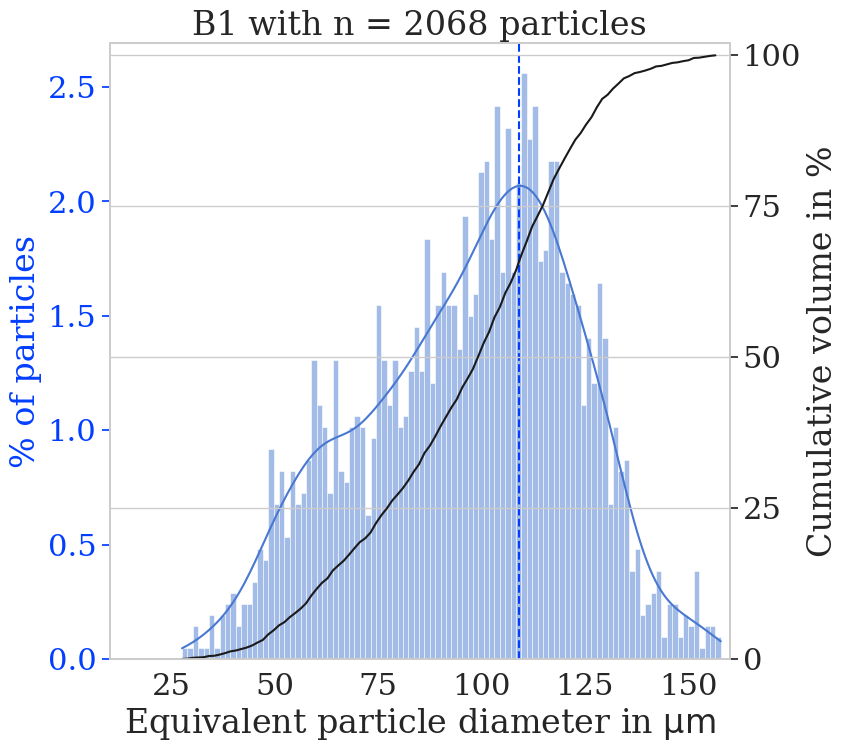

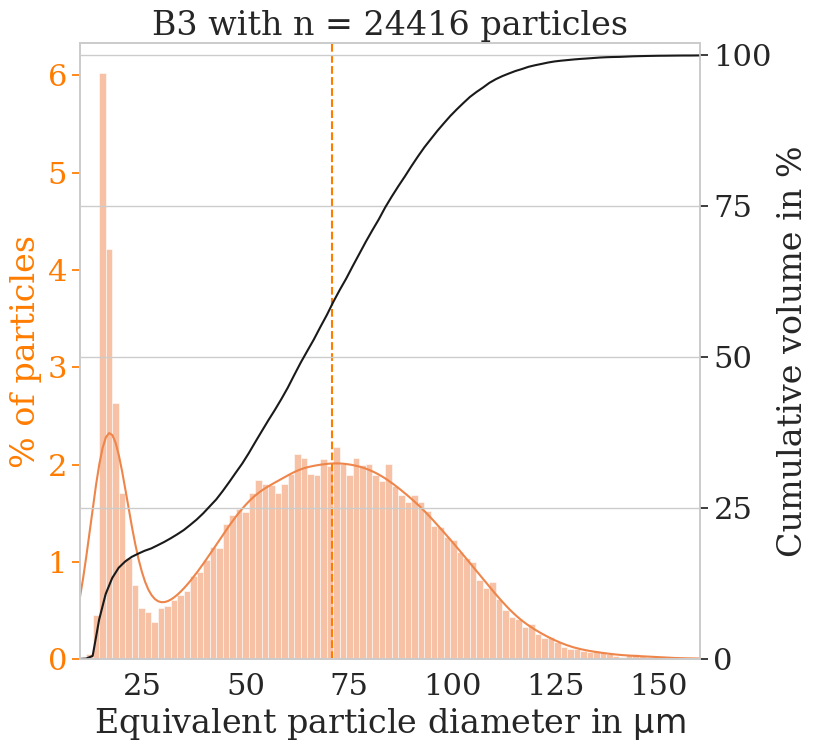

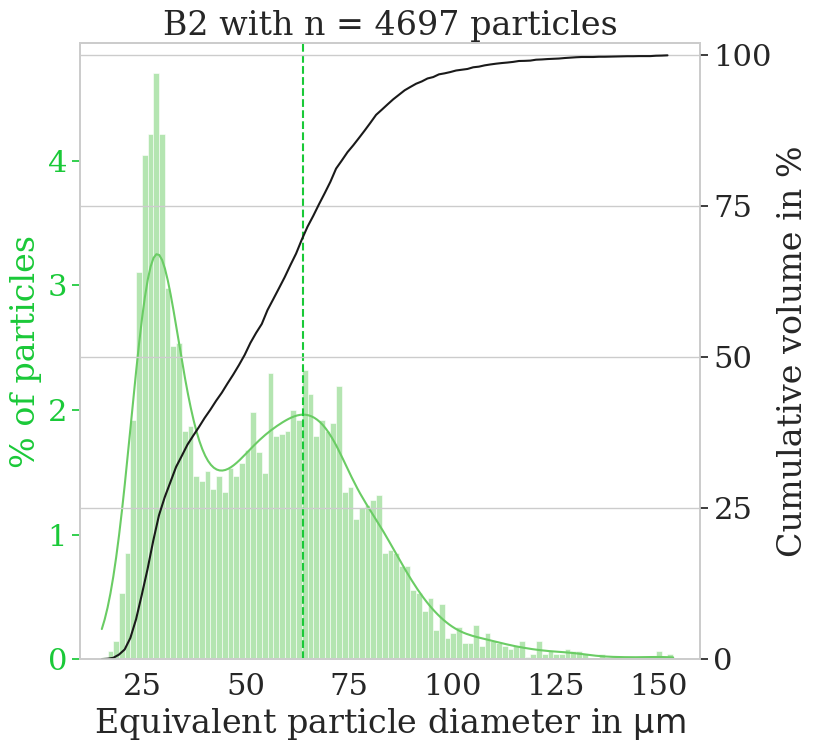

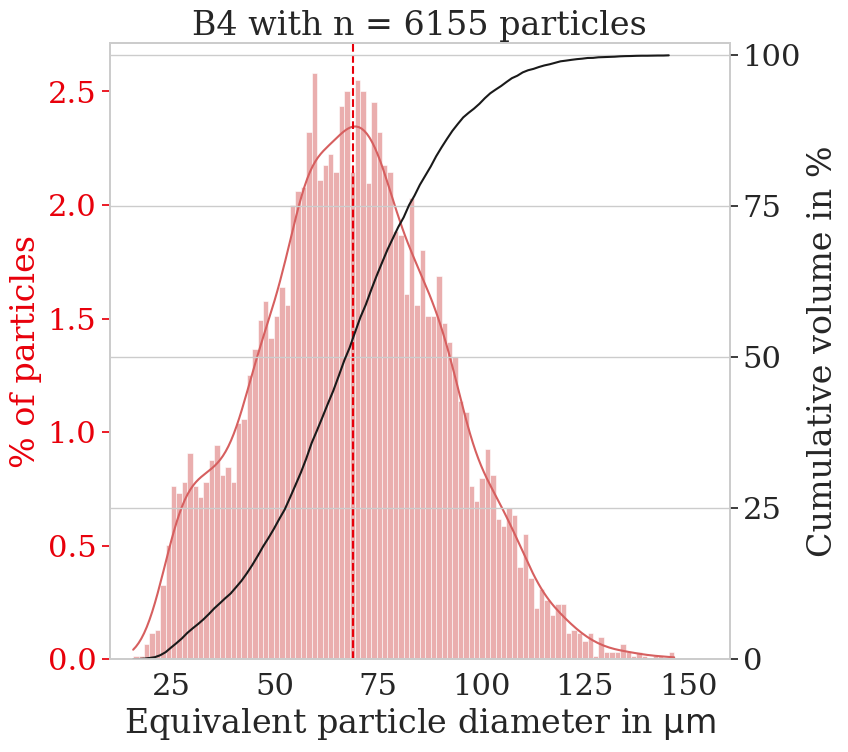

In [30]:
sns.set_context("paper")
sns.set_theme(font="serif", style="whitegrid", font_scale=2)
peaks = np.array([0.109, 0.071, 0.064, 0.069]) * 1e3
cmap = sns.color_palette("muted", 4)
cmap_line = sns.color_palette("bright", 4)

for ii, batch in enumerate(batch_names):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    print(cumulative_volume[batch]["x"][np.where(cumulative_volume[batch]["y"] >= 50)[0][0]])
    df = pd.DataFrame(diameter_distribution[batch],
                      columns=["Equivalent particle diameter in $\mathrm{\mu m}$"])
    sns.histplot(df,
                 x="Equivalent particle diameter in $\mathrm{\mu m}$",
                 bins=100,
                 ax=ax,
                 kde=True,
                 color=cmap[ii],
                 stat="percent")
    ax2 = ax.twinx()
    sns.lineplot(data=pd.DataFrame(cumulative_volume[batch]),
                 x="x",
                 y="y",
                 ax=ax2,
                 color="k")
    ax2.grid("minor")
    ax2.legend([], [], frameon=False)
    ax2.set_ylabel("Cumulative volume in %")
    ax2.set_ylim(0, 102)
    ax2.set_yticks(np.arange(0, 101, 25))
    ax.axvline(peaks[ii], color=cmap_line[ii], linestyle="--", label="Maximum of KDE: " + str(peaks[ii]) + " mm")
    # ax.legend(loc="upper left" if batch == "B2 (overetched)" else "upper right")
    ax.set_title(batch + " with n = " + str(len(diameter_distribution[batch])) + " particles")
    ax.set_ylabel('% of particles')
    ax.set_xlim(10, 160)
    ax.grid(False)
    ax.yaxis.label.set_color(cmap_line[ii])
    ax.tick_params(axis='y', colors=cmap_line[ii])
    fig.savefig("../../06_Results/ParticleSizeDistribution/" + batch + ".pdf", bbox_inches="tight", pad_inches=0)
    fig.savefig("../../06_Results/ParticleSizeDistribution/" + batch + ".png", bbox_inches="tight", pad_inches=0)

# Full quality scans and visualization

In [31]:
with open("../../06_Results/analytics_highQuality.pkl", "rb") as file:
    analytics = pickle.load(file)
specimen_overview = pd.read_csv("../../06_Results/specimen.csv", header=0, delimiter=";")

# Visualize region properties
Create the three image visualization for the bonding plane with density and contact percentage.

In [32]:
# for specimen in ANALYSIS_SPECIMEN:
#     path = "../../04_uCT/" + specimen + "/"
#     scan = Scan(path,
#                 downscale=True)
#     scan.load(logging=False)
# 
#     areas = analytics[specimen]["2d_cell_area"]
#     contact = analytics[specimen]["2d_contact_pct"]
#     stack = reslice(scan.get_mask(), "z")
#     image = stack[len(stack) // 2]
#     fig = visualize_region_properties(image, areas, contact, fig_width=30, font_scale=2)
#     fig.savefig("../../06_Results/RegionVisualizations/" + specimen + ".pdf", bbox_inches="tight", pad_inches=0)
#     fig.savefig("../../06_Results/RegionVisualizations/" + specimen + ".png", bbox_inches="tight", pad_inches=0)
#     plt.close(fig)

# Visualize region property correlation
Plot contact percentage against cell area for all specimens.

In [33]:
# for specimen in ANALYSIS_SPECIMEN:
#     areas = analytics[specimen]["2d_cell_area"] * SCALE_FACTOR_2D
#     contact = analytics[specimen]["2d_contact_pct"]
#     path = "../../06_Results/RegionCorrelations/" + specimen
#     fig = visualize_region_correlation(areas, contact)
#     fig.savefig(path + ".pdf", bbox_inches="tight", pad_inches=0)
#     fig.savefig(path + ".png", bbox_inches="tight", pad_inches=0)
#     plt.close(fig)

# Time constant testing
Contact between Al and PMMA depending on settings.

In [34]:
bad_specimen = [
    "AD33", # density is extremely high as calculated due to lots of small particles. Actual density from image is smaller.
    "AD31",  # uneven clamping pressure
]

# filter for correct specimen
df = specimen_overview[
    (specimen_overview["analysis"] == "y")
    & (~specimen_overview["specimen"].isin(bad_specimen))
    & ((specimen_overview["description"] == "time constant testing")
       | (specimen_overview["description"] == "standard setting batch test"))][["specimen", "settings", "Batch"]]

# expand settings into columns
settings = df["settings"].apply(lambda x: [int(ii) for ii in re.findall(r'\d+', x)]).values
all_settings = []
for setting in settings:
    if setting == []:  # Standard setting
        all_settings.append(
            get_func_gen_settings(on_time=0.01, off_time=0.02, passes=10, focus_distance=45, verbose=False))
    else:
        all_settings.append(
            get_func_gen_settings(on_time=setting[1] * 1e-3, off_time=setting[2] * 1e-3, passes=setting[0],
                                  focus_distance=45, verbose=False))
df = df.reset_index(drop=True)
df_settings = pd.DataFrame(all_settings)
df = df.join(df_settings[["actual_on_time", "actual_off_time", "passes"]])

# add additional information
df.replace(["B2", "B9", "B6", "B25"], ["B1", "B2", "B3", "B4"], inplace=True)
df["air_volume"] = [analytics[specimen]["mask_analytics"]["total_air_volume_mm3"] for specimen in
                    df["specimen"]]
df["Ratio off/on"] = np.round(df["actual_off_time"] / df["actual_on_time"])
df["Density in $\mathrm{mm}^{-2}$"] = [1 / (np.mean(analytics[specimen]["2d_cell_area"])) for specimen
                                       in df["specimen"]]
df["Contact"] = [100 - analytics[specimen]["mask_analytics"]["contact_air_Al_percent"] for specimen in df["specimen"]]
df = df.drop(["settings"], axis=1)
df["actual_on_time"] = df["actual_on_time"] * 1e3
df.rename({"passes": "Cycles", "actual_on_time": "On-time in ms"}, axis=1, inplace=True)

# create dataframes for the different visualizations
df_woBatch = df[df["Batch"] == "B3"].drop("Batch", axis=1)
df_batches = df[(df["On-time in ms"].round() == 10)
                & (df["Ratio off/on"] == 2.0)
                & (df["Cycles"] == 10)]
df

,specimen,Batch,On-time in ms,actual_off_time,Cycles,air_volume,Ratio off/on,Density in $\mathrm{mm}^{-2}$,Contact
0,AD67,B1,10.041667,0.020083,10,0.114425,2.0,39.099035,92.234655
1,AD66,B2,10.041667,0.020083,10,0.009732,2.0,288.065857,98.863082
2,AD64,B4,10.041667,0.020083,10,0.149269,2.0,99.696293,95.994805
3,AD63,B3,10.041667,0.020083,10,0.235127,2.0,81.774628,85.095097
4,AD45,B4,10.041667,0.020083,10,0.238061,2.0,66.101688,95.591348
5,AD43,B3,9.979296,0.019959,7,0.088356,2.0,79.205772,92.763711
6,AD42,B3,9.979296,0.019959,5,0.611413,2.0,58.390170,67.735132
7,AD40,B4,10.041667,0.020083,10,0.425847,2.0,72.221538,60.061254
8,AD38,B1,10.041667,0.020083,10,0.219343,2.0,43.198462,94.387182
9,AD36,B2,10.041667,0.020083,10,0.238371,2.0,274.147193,85.588889


# Settings overview

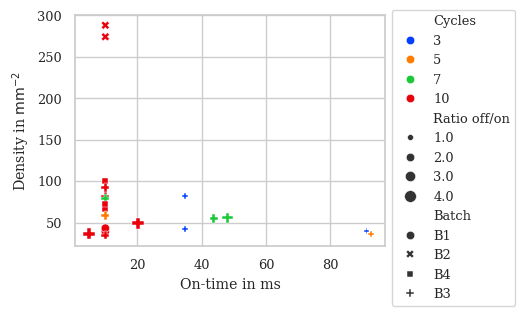

In [35]:
sns.set_context("paper")
sns.set_theme(font="serif", style="whitegrid", font_scale=0.85)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.scatterplot(data=df,
                x="On-time in ms",
                y="Density in $\mathrm{mm}^{-2}$",
                size="Ratio off/on",
                hue="Cycles",
                style="Batch",
                palette="bright",
                ax=ax, )
ax.legend(bbox_to_anchor=(1, 1.05))
ax.set_ylabel("Density in $\mathrm{mm}^{-2}$")
ax.set_xlabel("On-time in ms")
fig.savefig("../../06_Results/SettingsTest/param_overview.pdf", bbox_inches="tight", pad_inches=0)
fig.savefig("../../06_Results/SettingsTest/param_overview.png", bbox_inches="tight", pad_inches=0)

# Parameter influence with standard batch B6

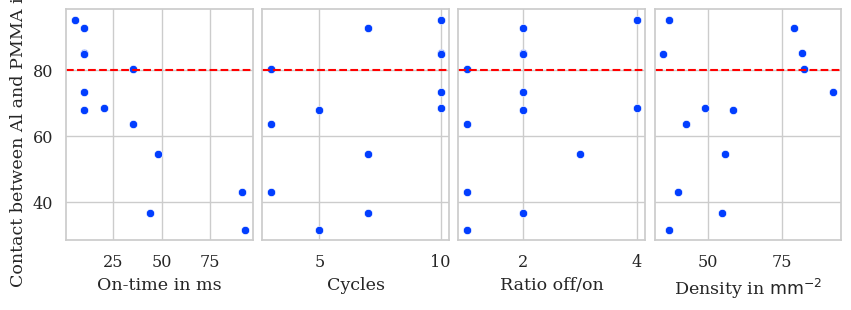

In [36]:
sns.set_context("paper")
sns.set_theme(font="serif", style="whitegrid", font_scale=1.05)

bright = sns.color_palette("bright", 1)
fig, axs = plt.subplots(1, 4, figsize=(10, 3), sharey=True)
fig.subplots_adjust(wspace=0.05)
[ax.axhline(80, color="red", linestyle="--") for ax in axs]
sns.scatterplot(data=df_woBatch, x="On-time in ms", y="Contact", ax=axs[0], color=bright)
sns.scatterplot(data=df_woBatch, x="Cycles", y="Contact", ax=axs[1], color=bright,
                legend=False)
sns.scatterplot(data=df_woBatch, x="Ratio off/on", y="Contact", ax=axs[2], color=bright,
                legend=False)
sns.scatterplot(data=df_woBatch, x="Density in $\mathrm{mm}^{-2}$", y="Contact", ax=axs[3], color=bright, legend=False)
axs[0].set_ylabel("Contact between Al and PMMA in %")
fig.savefig("../../06_Results/SettingsTest/onEnergyPasses_contact.pdf", bbox_inches="tight", pad_inches=0)
fig.savefig("../../06_Results/SettingsTest/onEnergyPasses_contact.png", bbox_inches="tight", pad_inches=0)

# Standard Settings, different batches

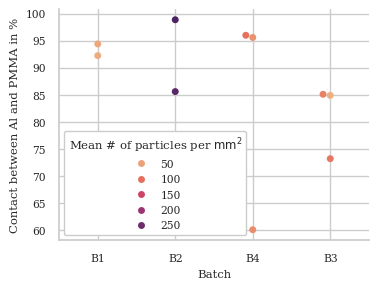

In [37]:
sns.set_context("paper")
sns.set_theme(font="serif", style="whitegrid", font_scale=0.7)
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
sns.swarmplot(data=df_batches,
                x="Batch",
                y="Contact",
                hue="Density in $\mathrm{mm}^{-2}$",
                palette="flare",
                ax=ax)
ax.set_ylabel("Contact between Al and PMMA in %")
ax.set_xlabel("Batch")
ax.legend(title="Mean # of particles per $\mathrm{mm}^2$", framealpha=1)
sns.despine(ax=ax)
ax.grid(axis="x")
fig.savefig("../../06_Results/SettingsTest/StandardSetting_Batches.pdf", bbox_inches="tight", pad_inches=0)
fig.savefig("../../06_Results/SettingsTest/StandardSetting_Batches.png", bbox_inches="tight", pad_inches=0)